In [1]:
import os
import sys
import warnings
import time

sys.path.insert(0, os.path.abspath(os.path.join("..", "src")))
warnings.simplefilter("ignore")

import tensorflow as tf
import numpy as np
from keras import mixed_precision
from keras.applications.vgg16 import VGG16
from keras.models import Model

physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print(f"Using device: {physical_devices[0]}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU device found, using CPU")

print(mixed_precision.global_policy())
# mixed_precision.set_global_policy('mixed_float16')

from models import create_dataset_from_mapping_vgg

root_dir = os.path.abspath(os.path.join(".", ".."))

No GPU device found, using CPU
<FloatDTypePolicy "float32">


In [2]:
train_dataset = create_dataset_from_mapping_vgg(mapping_file="train_mapping.csv").batch(256).prefetch(tf.data.experimental.AUTOTUNE)

In [3]:
model = VGG16(weights='imagenet', include_top=True)
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [4]:
X_train = model.predict(train_dataset.take(25))

25/25 ━━━━━━━━━━━━━━━━━━━━ 1199s 48s/step


In [5]:
X_train.shape

(6400, 4096)

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99, random_state=42)
train_features = pca.fit_transform(X_train)
# validation_features = pca.transform(val_images)
n_components = pca.n_components_
print(f"Number of components to retain 99% variance: {n_components}")

# Verify the shapes of the transformed features
print(f"Shape of train features after PCA: {train_features.shape}")
# print(f"Shape of validation features after PCA: {validation_features.shape}")

Number of components to retain 99% variance: 1387
Shape of train features after PCA: (6400, 1387)


In [7]:
x = train_features 

In [8]:
x.shape

(6400, 1387)

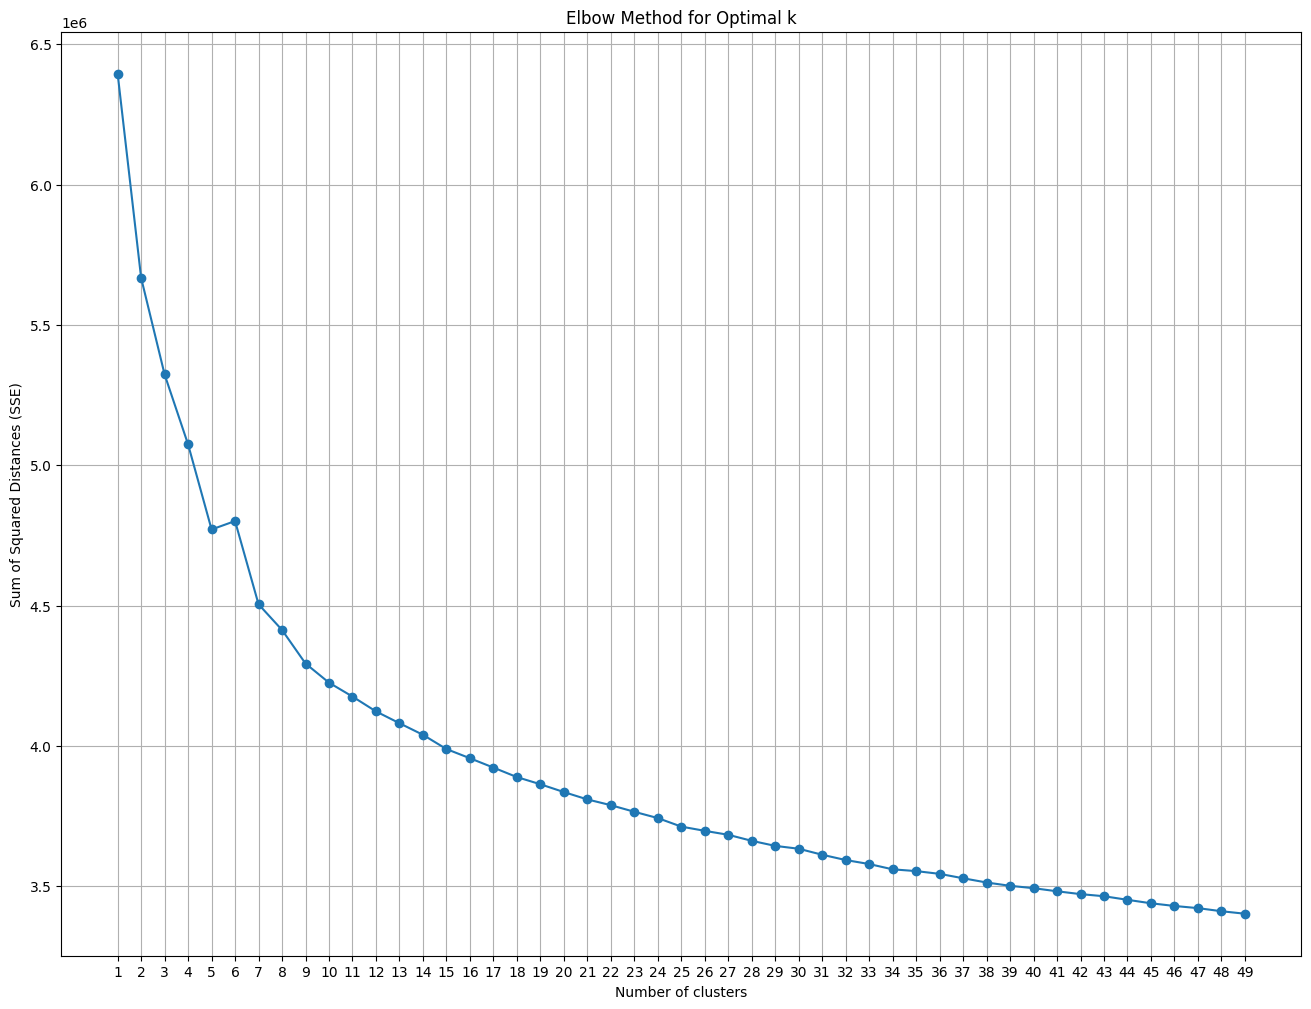

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
sse = []
list_k = list(range(1, 50))

for k in list_k:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(x)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(16, 12))
plt.plot(list_k, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.title('Elbow Method for Optimal k')
plt.xticks(list_k)
plt.grid(True)
plt.show()

Clustering:   0%|          | 0/18 [00:00<?, ?it/s]

Clustering: 100%|██████████| 18/18 [00:38<00:00,  2.16s/it]


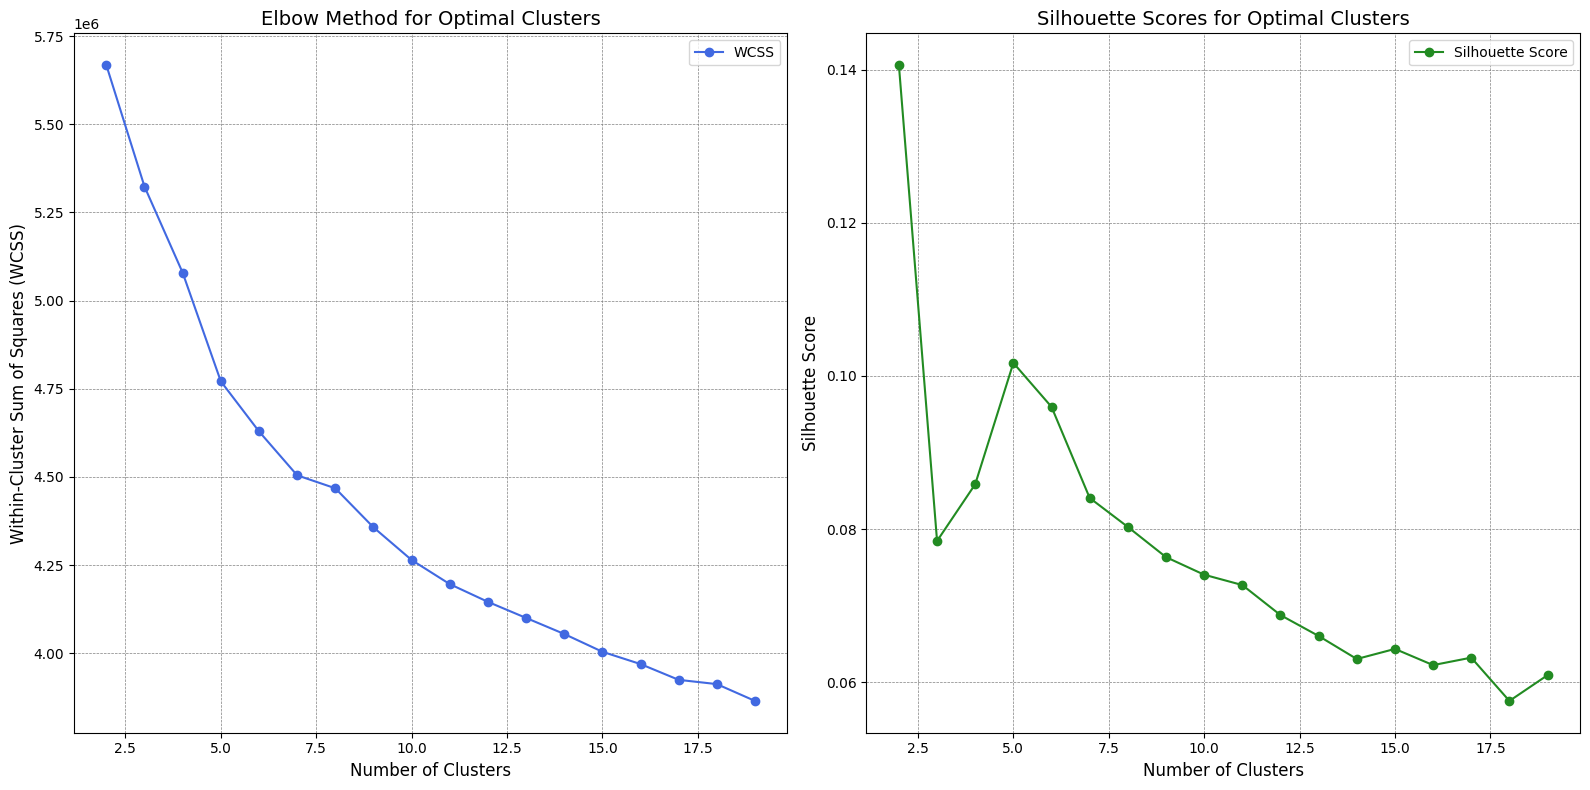

In [10]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
cluster_range = range(2, 20)

wcss = []
silhouette_scores = []
for n_clusters in tqdm(cluster_range, desc="Clustering", total=len(cluster_range)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(x)
    
    wcss.append(kmeans.inertia_)
    
    silhouette_avg = silhouette_score(x, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, wcss, marker='o', linestyle='-', color='royalblue', label='WCSS')
plt.title('Elbow Method for Optimal Clusters', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='forestgreen', label='Silhouette Score')
plt.title('Silhouette Scores for Optimal Clusters', fontsize=14)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.legend()
plt.tight_layout()
plt.show()

We can see that the silouette scores are much worse than with efficent net so will stick with the efficent net

In [15]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

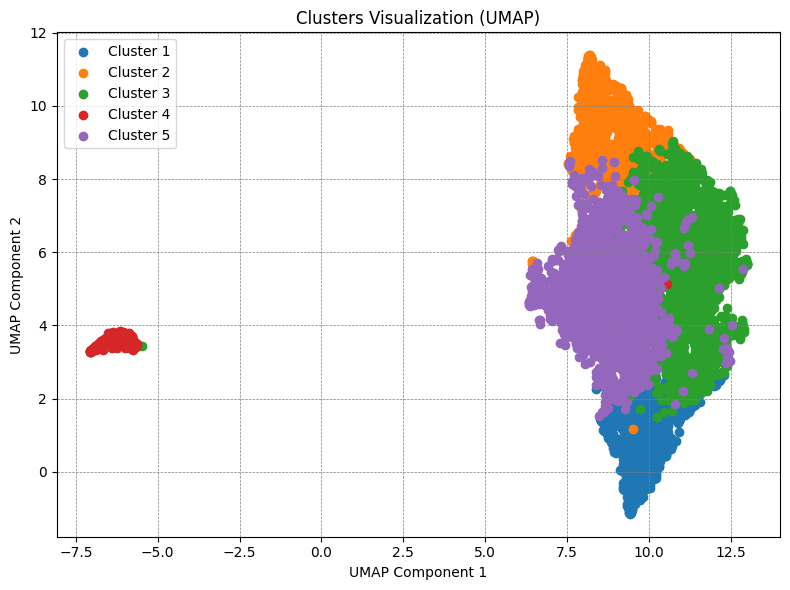

In [16]:
from models import plot_clusters_scatter_umap_3d, plot_clusters_scatter_umap
cluster_labels = kmeans.fit_predict(X_train)
plot_clusters_scatter_umap(X_train, cluster_labels, n_clusters)


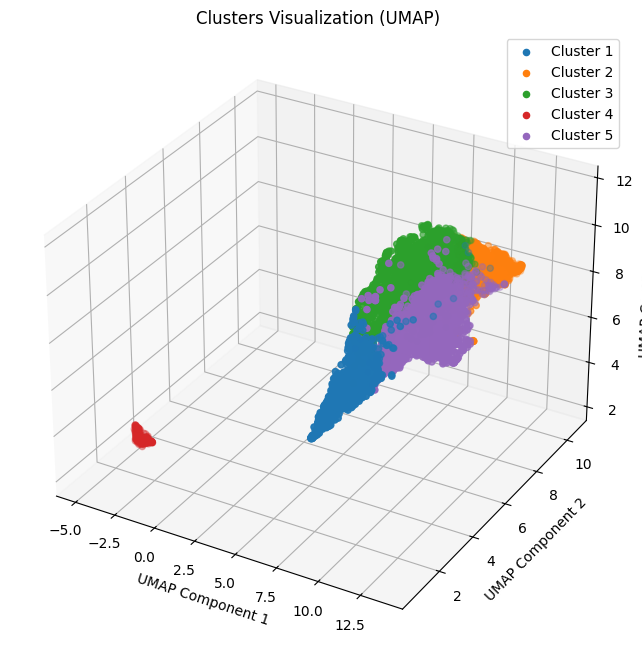

In [17]:
plot_clusters_scatter_umap_3d(X_train, cluster_labels, n_clusters)